In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import haversine as hs
from GCN_Regression import GCN_RegressionModel
from Trainer import Trainer
data = xr.open_dataset("../AQ - Experiments/data/delhi_cpcb_2022.nc")

data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df = data.to_dataframe()
# df = df["2022-01-01": "2022-12-31"]
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [4]:
def get_distance(lat1, lon1, lat2, lon2):
    return hs.haversine((lat1, lon1), (lat2, lon2))

In [5]:
# Define the distance threshold for G1 (in kilometers)
distance_threshold_1 = 12

# Create an empty nx graph
G1 = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    G1.add_node(i, latitude=lat1, longitude=lon1, pm=pm)
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        distance = get_distance(lat1, lon1, lat2, lon2)
        if distance <= distance_threshold_1:
            G1.add_edge(i, j)

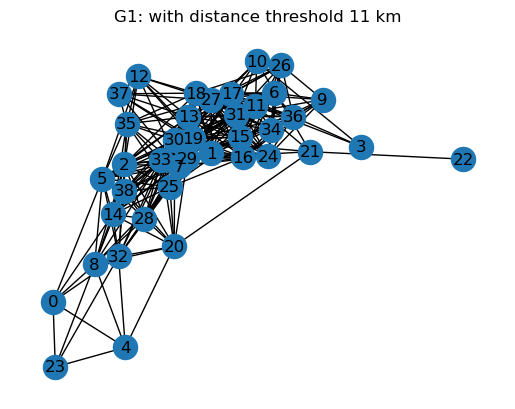

In [6]:
layout1 = nx.spring_layout(G1, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
plt.title("G1: with distance threshold 11 km")
nx.draw(G1, pos=layout1, with_labels=True)
plt.show()

In [7]:
node_features = [(G1.nodes[node]['latitude'], G1.nodes[node]['longitude']) for node in G1.nodes]
edge_index = torch.tensor(list(G1.edges)).t().contiguous()
y = torch.tensor([G1.nodes[node]['pm'] for node in G1.nodes], dtype=torch.float).view(-1, 1)
sorted_nodes = sorted(G1.nodes(), key=lambda node: G1.nodes[node]['latitude'])

# Divide train and test masks based on the sorted latitudes
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G1.nodes):
    lat = G1.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_RegressionModel(2)


In [10]:
trainer = Trainer(model = model, data = data1, device = device, epochs=1000)
trainer.train(lr=0.01)

Epoch 0: Train RMSE 108.2321, Test RMSE 95.0712
Epoch 100: Train RMSE 47.0954, Test RMSE 37.1723
Epoch 200: Train RMSE 46.7960, Test RMSE 36.8000
Epoch 300: Train RMSE 46.3626, Test RMSE 36.4994
Epoch 400: Train RMSE 45.5321, Test RMSE 35.8782
Epoch 500: Train RMSE 41.9491, Test RMSE 32.3615
Epoch 600: Train RMSE 37.9112, Test RMSE 27.4546
Epoch 700: Train RMSE 37.6480, Test RMSE 28.5777
Epoch 800: Train RMSE 37.5340, Test RMSE 27.5008
Epoch 900: Train RMSE 37.3439, Test RMSE 28.0291
